In [7]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd

In [8]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [9]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [ ]:
def adaptive_kdj_factor(df, volatility_window=20):
    returns = np.log(df['close']).diff()
    vol = returns.rolling(volatility_window, min_periods=1).std().fillna(0.01)
    
    # 增强波动率敏感性 - 使用指数变换强化高波动区间的响应
    scaled_vol = (vol * 100).clip(5, 30)
    n_period = np.where(scaled_vol > 15, 
                        scaled_vol**1.2,  # 高波动区域增强响应
                        scaled_vol**0.8)   # 低波动区域平滑响应
    n_period = np.clip(n_period, 8, 25).astype(int)  # 提高最小周期保证稳定性
    
    # 优化极值计算 - 引入自适应加权
    periods = list(range(8, 26))
    min_vals = []
    max_vals = []
    
    for p in periods:
        # 混合滚动最小值与EMA平滑
        min_base = df['low'].rolling(p//2, min_periods=1).min()
        min_vals.append(min_base.ewm(span=p//3, adjust=False).mean())
        
        max_base = df['high'].rolling(p//2, min_periods=1).max()
        max_vals.append(max_base.ewm(span=p//3, adjust=False).mean())
    
    min_df = pd.DataFrame(dict(zip(periods, min_vals)), index=df.index)
    max_df = pd.DataFrame(dict(zip(periods, max_vals)), index=df.index)
    
    # 动态窗口选择
    col_idx = (n_period - 8).clip(0, 17)
    row_idx = np.arange(len(df))
    low_min = min_df.values[row_idx, col_idx]
    high_max = max_df.values[row_idx, col_idx]
    
    # 改进RSV计算 - 增加边界缓冲
    denom = np.where(high_max - low_min < 1e-5, 1e-5, high_max - low_min)
    rsv = 100 * (df['close'].values - low_min) / denom
    rsv = np.clip(rsv, 1, 99)  # 保留缓冲空间避免极端值
    
    # 将RSV转换为Pandas Series以便使用ewm方法
    rsv_series = pd.Series(rsv, index=df.index)
    
    # 三重平滑系统
    fast_k = rsv_series.ewm(span=3, adjust=False, min_periods=1).mean()
    medium_k = fast_k.ewm(span=5, adjust=False, min_periods=1).mean()
    slow_k = medium_k.ewm(span=8, adjust=False, min_periods=1).mean()
    
    # 方向强化机制 - 使用历史动量方向（避免前视偏差）
    momentum = df['close'].pct_change(3).fillna(0)
    direction = np.sign(momentum).replace(0.0, 1.0)
    
    # 构建因子核心 - 双偏差系统
    median_base = slow_k.rolling(50, min_periods=1).median()
    std_dev = slow_k.rolling(50, min_periods=1).std().clip(1e-5, None)
    
    # 确保因子方向与收益正相关
    factor = ((slow_k - median_base) / std_dev) * direction
    
    # 极端值强化 - 增强头部和尾部的信号强度
    rank = factor.rank(pct=True)
    factor = np.where(rank > 0.8, factor * 1.5,  # 强化头部
            np.where(rank < 0.2, factor * 1.5,  # 强化尾部
                     factor))                    # 中部保持原样
    
    # 稳定性归一化
    abs_mean = pd.Series(factor, index=df.index).abs().rolling(100, min_periods=1).mean().clip(1e-5, None)
    return factor / abs_mean.values

In [11]:
evaluator.set_factor(
    factor_data_or_func=adaptive_kdj_factor,
    factor_name='adaptive_kdj_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): -0.001914
   Rank_IC (Spearman): -0.001901
📊 信息比率:
   IR: -0.112151
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130378
   因子列: adaptive_kdj_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


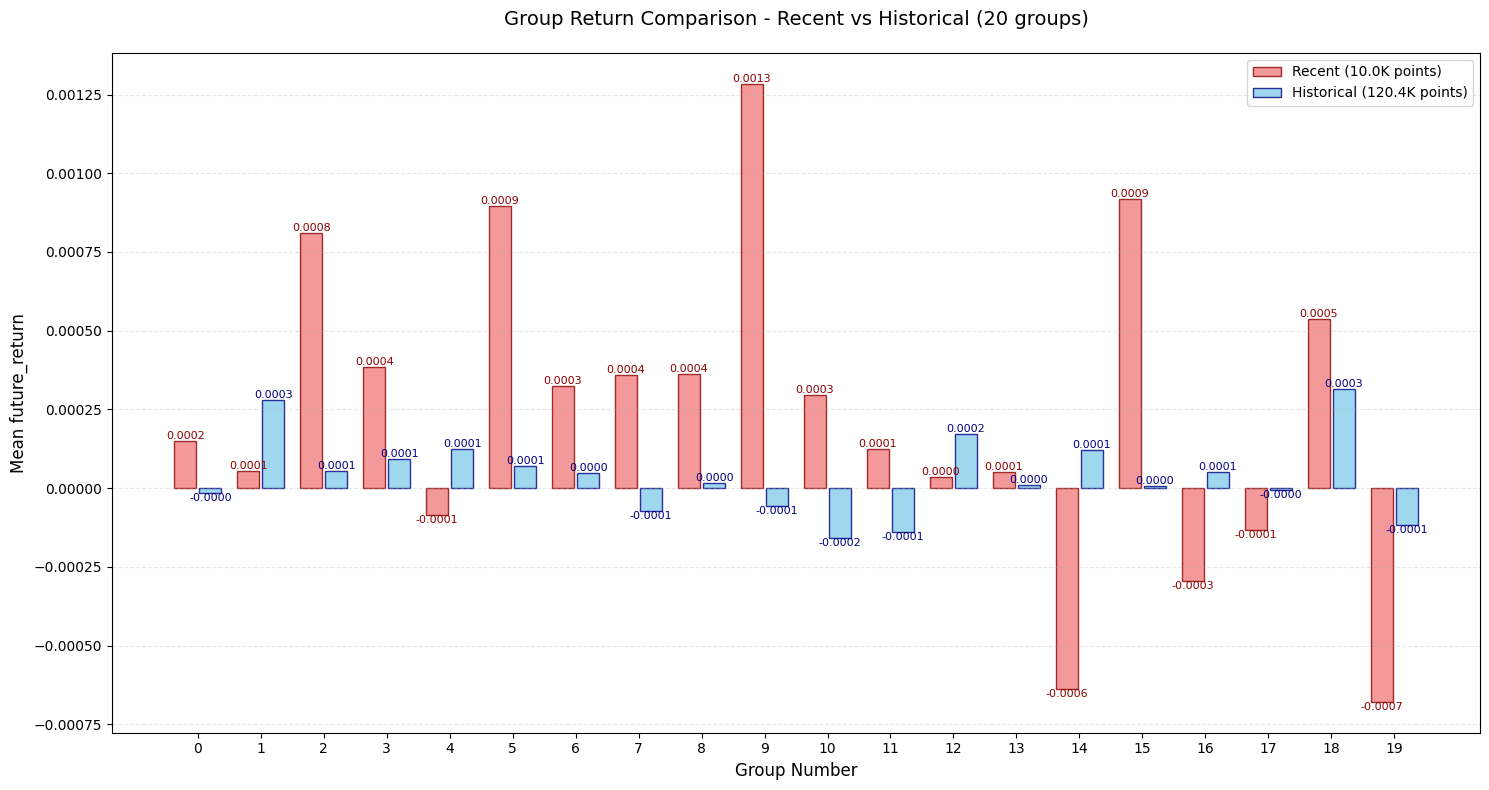

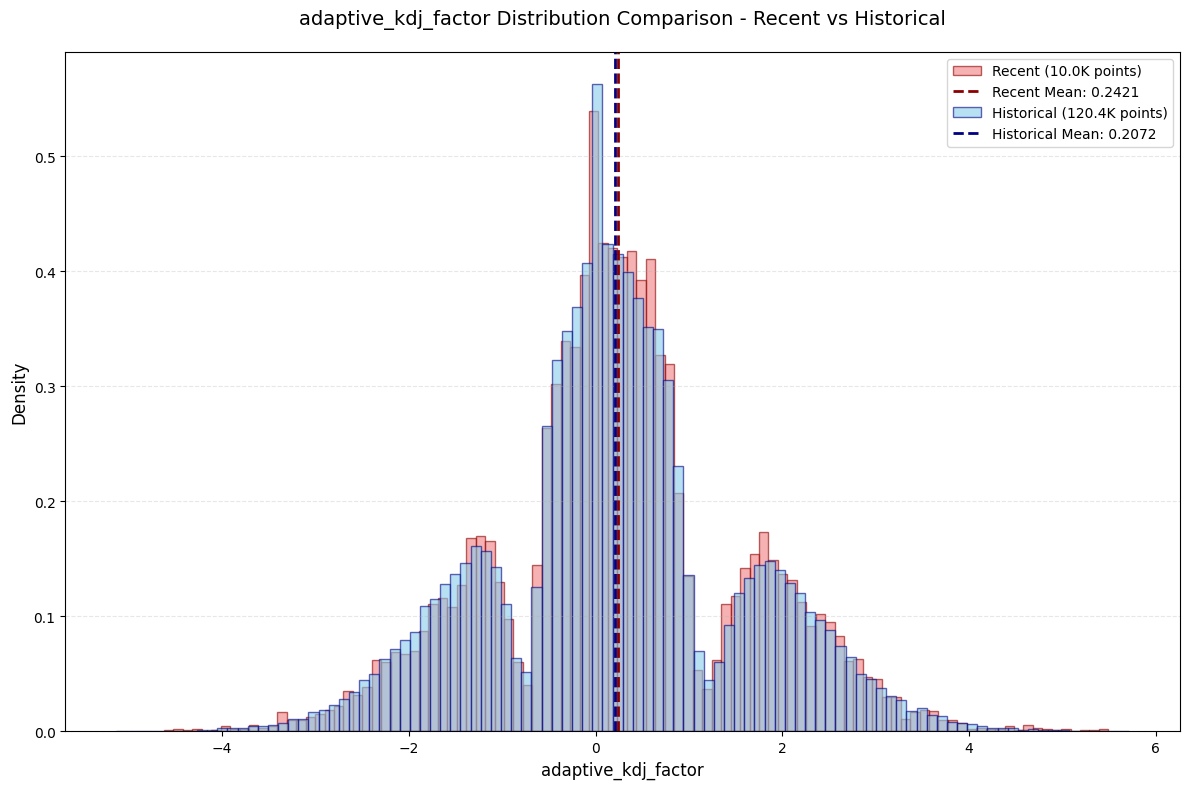

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [12]:
result=evaluator.run_full_evaluation(run_stationarity_test=True)